In [1]:
import pandas as pd

# Abnormal return dataset
returns = pd.read_csv("event_study_abnormal_returns_panel_10_20_v2.csv")

# EPS surprise dataset
eps_data = pd.read_csv("av_eps_quarterly.csv")

In [2]:
# ***Make ticker column consistent***
if "symbol" in eps_data.columns and "ticker" not in eps_data.columns:
    eps_data = eps_data.rename(columns={"symbol": "ticker"})

# Parse dates
eps_data["reportedDate"] = pd.to_datetime(eps_data["reportedDate"])
eps_data["fiscalDateEnding"] = pd.to_datetime(eps_data["fiscalDateEnding"])

In [3]:
returns

,event_id,ticker,date,event_day,abnormal_return
0,AAPL_2005-07-13,AAPL,2005-07-05,-8,0.026191
1,AAPL_2005-07-13,AAPL,2005-07-06,-7,-0.006099
2,AAPL_2005-07-13,AAPL,2005-07-07,-6,-0.006843
3,AAPL_2005-07-13,AAPL,2005-07-08,-5,-0.011699
4,AAPL_2005-07-13,AAPL,2005-07-11,-2,-0.027788
...,...,...,...,...,...
5367,NVDA_2025-11-19,NVDA,2025-12-03,14,-0.013356
5368,NVDA_2025-11-19,NVDA,2025-12-04,15,0.017410
5369,NVDA_2025-11-19,NVDA,2025-12-05,16,-0.010310
5370,NVDA_2025-11-19,NVDA,2025-12-08,19,0.018580


In [4]:
eps_data

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,ticker
0,2025-09-30,2025-10-30,1.850,1.760,0.090,5.1136,post-market,AAPL
1,2025-06-30,2025-07-31,1.570,1.430,0.140,9.7902,post-market,AAPL
2,2025-03-31,2025-05-01,1.650,1.620,0.030,1.8519,post-market,AAPL
3,2024-12-31,2025-01-30,2.400,2.340,0.060,2.5641,post-market,AAPL
4,2024-09-30,2024-10-31,0.970,0.950,0.020,2.1053,post-market,AAPL
...,...,...,...,...,...,...,...,...
306,2000-04-30,2000-05-16,0.001,0.001,0.000,0.0000,pre-market,NVDA
307,2000-01-31,2000-02-15,0.001,0.001,0.000,0.0000,pre-market,NVDA
308,1999-10-31,1999-11-18,0.001,0.002,-0.001,-50.0000,pre-market,NVDA
309,1999-07-31,1999-08-18,0.002,0.002,0.000,0.0000,pre-market,NVDA


In [5]:
# Split event_id into ticker and quarter_end
# returns[["ticker_from_id", "quarter_end"]] = returns["event_id"].str.split("_", expand=True)

# Convert quarter_end to datetime
# returns["quarter_end"] = pd.to_datetime(returns["quarter_end"])

# ***Correction***
returns[["ticker_from_id", "event_date"]] = returns["event_id"].str.split("_", expand=True)
returns["event_date"] = pd.to_datetime(returns["event_date"])

In [6]:
# Rename symbol to ticker for consistency
eps_data = eps_data.rename(columns={"symbol": "ticker"})

# Convert fiscalDateEnding to datetime
eps_data["fiscalDateEnding"] = pd.to_datetime(eps_data["fiscalDateEnding"])

In [7]:
# merged = returns.merge(
    # eps_data,
    # left_on=["ticker_from_id", "quarter_end"],
    # right_on=["ticker", "fiscalDateEnding"],
    # how="inner"
#)

# ***Correction***
merged = returns.merge(
    eps_data,
    left_on=["ticker_from_id", "event_date"],
    right_on=["ticker", "reportedDate"],
    how="inner"   # or "left" while you debug
)

# print("Merged dataset sample:")
# print(merged.head())

# ***Correction***
print(merged["reportedEPS"].isna().mean())  # share of unmatched rows

0.0


In [8]:
# ***Addition*
merged = merged.sort_values(["event_id", "event_day"])
merged["CAR"] = merged.groupby("event_id")["abnormal_return"].cumsum()

In [9]:
# Sanity check
print("Merged shape:", merged.shape)
print("Unique events:", merged["event_id"].nunique())
print("Tickers:", merged["ticker_from_id"].unique())

Merged shape: (5372, 16)
Unique events: 248
Tickers: ['AAPL' 'GOOGL' 'NVDA']


In [10]:
merged

,event_id,ticker_x,date,event_day,abnormal_return,ticker_from_id,event_date,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,ticker_y,CAR
0,AAPL_2005-07-13,AAPL,2005-07-05,-8,0.026191,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.026191
1,AAPL_2005-07-13,AAPL,2005-07-06,-7,-0.006099,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.020092
2,AAPL_2005-07-13,AAPL,2005-07-07,-6,-0.006843,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.013248
3,AAPL_2005-07-13,AAPL,2005-07-08,-5,-0.011699,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.001549
4,AAPL_2005-07-13,AAPL,2005-07-11,-2,-0.027788,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,-0.026239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,NVDA_2025-11-19,NVDA,2025-12-03,14,-0.013356,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.080693
5368,NVDA_2025-11-19,NVDA,2025-12-04,15,0.017410,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.063283
5369,NVDA_2025-11-19,NVDA,2025-12-05,16,-0.010310,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.073593
5370,NVDA_2025-11-19,NVDA,2025-12-08,19,0.018580,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.055012


In [11]:
#Step 4: Categorization + Frequency by Stock
# A. Categorize EPS Events
def categorize_surprise(row):
    if row["surprisePercentage"] < -5:
        return "Negative Surprise"
    elif -5 <= row["surprisePercentage"] <= 5:
        return "Neutral/Small Surprise"
    else:
        return "Positive Surprise"

merged["EPS_Category"] = merged.apply(categorize_surprise, axis=1)
merged

,event_id,ticker_x,date,event_day,abnormal_return,ticker_from_id,event_date,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,ticker_y,CAR,EPS_Category
0,AAPL_2005-07-13,AAPL,2005-07-05,-8,0.026191,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.026191,Neutral/Small Surprise
1,AAPL_2005-07-13,AAPL,2005-07-06,-7,-0.006099,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.020092,Neutral/Small Surprise
2,AAPL_2005-07-13,AAPL,2005-07-07,-6,-0.006843,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.013248,Neutral/Small Surprise
3,AAPL_2005-07-13,AAPL,2005-07-08,-5,-0.011699,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,0.001549,Neutral/Small Surprise
4,AAPL_2005-07-13,AAPL,2005-07-11,-2,-0.027788,AAPL,2005-07-13,2005-06-30,2005-07-13,0.01,0.01,0.00,0.0000,post-market,AAPL,-0.026239,Neutral/Small Surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,NVDA_2025-11-19,NVDA,2025-12-03,14,-0.013356,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.080693,Neutral/Small Surprise
5368,NVDA_2025-11-19,NVDA,2025-12-04,15,0.017410,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.063283,Neutral/Small Surprise
5369,NVDA_2025-11-19,NVDA,2025-12-05,16,-0.010310,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.073593,Neutral/Small Surprise
5370,NVDA_2025-11-19,NVDA,2025-12-08,19,0.018580,NVDA,2025-11-19,2025-10-31,2025-11-19,1.30,1.24,0.06,4.8387,post-market,NVDA,-0.055012,Neutral/Small Surprise


In [12]:
# Save DataFrame to CSV
merged.to_excel("merged.xlsx", index=False)

In [13]:
#B. Overall Frequency of EPS Categories
freq_by_cat = merged.groupby(["ticker_from_id", "EPS_Category"])["reportedDate"].nunique().reset_index()
freq_by_cat.columns = ["Stock", "EPS_Category", "Announcement_Count"]

print("Announcements by stock and EPS category:")
print(freq_by_cat.head())

Announcements by stock and EPS category:
   Stock            EPS_Category  Announcement_Count
0   AAPL       Negative Surprise                   1
1   AAPL  Neutral/Small Surprise                  40
2   AAPL       Positive Surprise                  41
3  GOOGL       Negative Surprise                  10
4  GOOGL  Neutral/Small Surprise                  34


In [14]:
#C. Normalized Frequency (Percentages per Stock)
import matplotlib.pyplot as plt

# Pivot to wide format
pivot_freq = freq_by_cat.pivot(index="Stock", columns="EPS_Category", values="Announcement_Count").fillna(0)

# Add row totals
pivot_freq["Total"] = pivot_freq.sum(axis=1)

# Normalize to percentages
pivot_freq_pct = pivot_freq.div(pivot_freq["Total"], axis=0) * 100
pivot_freq_pct = pivot_freq_pct.drop(columns="Total")

print("Percentage distribution of EPS categories per stock:")
print(pivot_freq_pct.head())

Percentage distribution of EPS categories per stock:
EPS_Category  Negative Surprise  Neutral/Small Surprise  Positive Surprise
Stock                                                                     
AAPL                   1.219512               48.780488          50.000000
GOOGL                 12.048193               40.963855          46.987952
NVDA                   6.024096               22.891566          71.084337


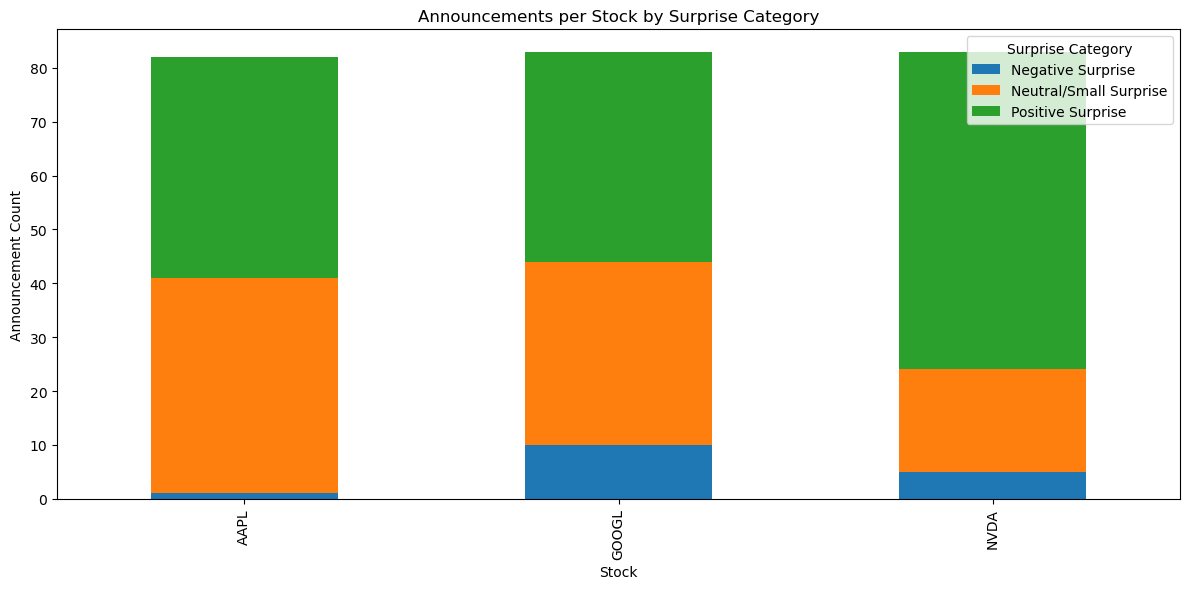

In [15]:
pivot_freq = freq_by_cat.pivot(index="Stock", columns="EPS_Category", values="Announcement_Count").fillna(0)

pivot_freq.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Announcements per Stock by Surprise Category")
plt.xlabel("Stock")
plt.ylabel("Announcement Count")
plt.xticks(rotation=90)
plt.legend(title="Surprise Category")
plt.tight_layout()
plt.show()

In [16]:
# Compute CAR per event (ticker + announcement date)
merged["CAR"] = merged.groupby(["ticker_from_id", "reportedDate"])["abnormal_return"].cumsum()

print("CAR sample:")
print(merged[["ticker_from_id", "reportedDate", "event_day", "abnormal_return", "CAR"]].head())

CAR sample:
  ticker_from_id reportedDate  event_day  abnormal_return       CAR
0           AAPL   2005-07-13         -8         0.026191  0.026191
1           AAPL   2005-07-13         -7        -0.006099  0.020092
2           AAPL   2005-07-13         -6        -0.006843  0.013248
3           AAPL   2005-07-13         -5        -0.011699  0.001549
4           AAPL   2005-07-13         -2        -0.027788 -0.026239


In [17]:
# Compute CAR per event (ticker + announcement date)
merged["CAR"] = merged.groupby(["ticker_from_id", "reportedDate"])["abnormal_return"].cumsum()

In [18]:
# Keep only event_day >= 0 (announcement day and after)
post_announcement = merged[merged["event_day"] >= 0]

In [19]:
avg_car_post = post_announcement.groupby(["EPS_Category", "event_day"])["CAR"].mean().reset_index()

print("Average CAR per EPS category (post-announcement):")
print(avg_car_post.head())

Average CAR per EPS category (post-announcement):
        EPS_Category  event_day       CAR
0  Negative Surprise          0  0.001728
1  Negative Surprise          1 -0.014769
2  Negative Surprise          2 -0.030579
3  Negative Surprise          3 -0.037579
4  Negative Surprise          4 -0.017962


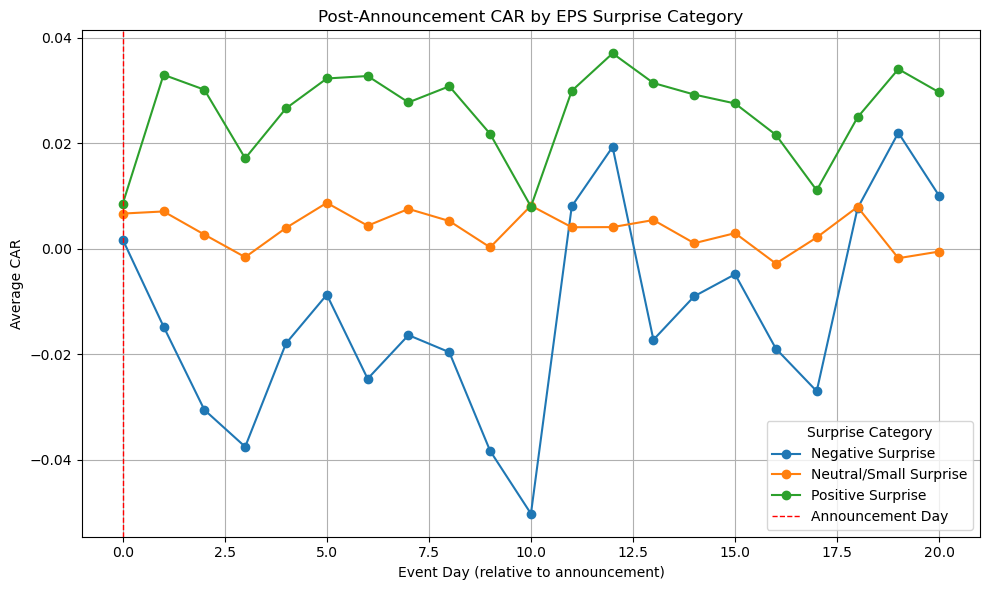

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for cat in avg_car_post["EPS_Category"].unique():
    subset = avg_car_post[avg_car_post["EPS_Category"] == cat]
    plt.plot(subset["event_day"], subset["CAR"], marker="o", label=cat)

plt.axvline(x=0, color="red", linestyle="--", linewidth=1, label="Announcement Day")
plt.title("Post-Announcement CAR by EPS Surprise Category")
plt.xlabel("Event Day (relative to announcement)")
plt.ylabel("Average CAR")
plt.legend(title="Surprise Category")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
avg_car_stock = post_announcement.groupby(["ticker_from_id", "event_day"])["CAR"].mean().reset_index()

print("Average CAR per stock (post-announcement):")
print(avg_car_stock.head())


Average CAR per stock (post-announcement):
  ticker_from_id  event_day       CAR
0           AAPL          0  0.000608
1           AAPL          1  0.012820
2           AAPL          2  0.016652
3           AAPL          3  0.008605
4           AAPL          4 -0.003310


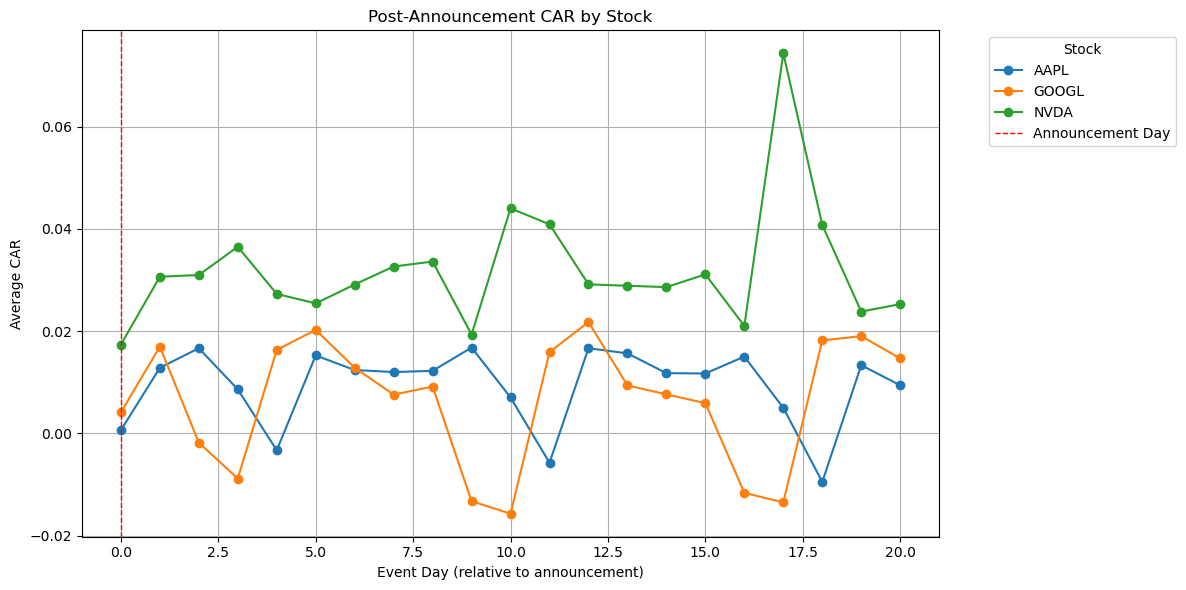

In [22]:
plt.figure(figsize=(12,6))

for stock in avg_car_stock["ticker_from_id"].unique():
    subset = avg_car_stock[avg_car_stock["ticker_from_id"] == stock]
    plt.plot(subset["event_day"], subset["CAR"], marker="o", label=stock)

plt.axvline(x=0, color="red", linestyle="--", linewidth=1, label="Announcement Day")
plt.title("Post-Announcement CAR by Stock")
plt.xlabel("Event Day (relative to announcement)")
plt.ylabel("Average CAR")
plt.legend(title="Stock", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Compute CAR per event (ticker + announcement date)
merged["CAR"] = merged.groupby(["ticker_from_id", "reportedDate"])["abnormal_return"].cumsum()

In [24]:
post_announcement = merged[merged["event_day"] >= 0]

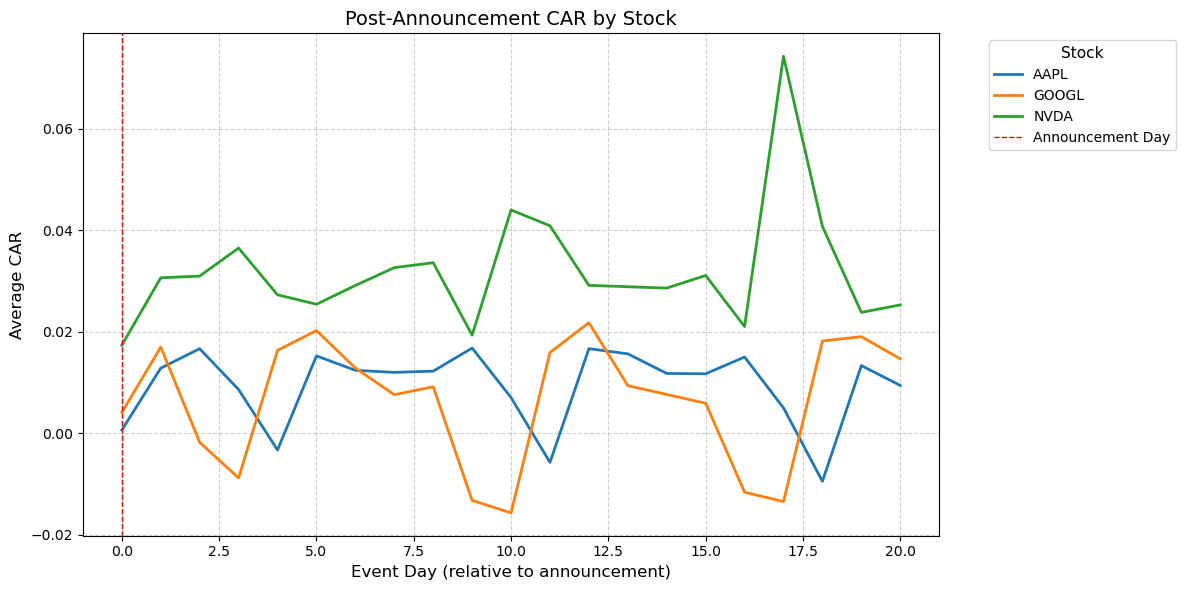

In [25]:
plt.figure(figsize=(12,6))

for stock in avg_car_stock["ticker_from_id"].unique():
    subset = avg_car_stock[avg_car_stock["ticker_from_id"] == stock]
    plt.plot(subset["event_day"], subset["CAR"], linewidth=2, label=stock)

plt.axvline(x=0, color="red", linestyle="--", linewidth=1, label="Announcement Day")
plt.title("Post-Announcement CAR by Stock", fontsize=14)
plt.xlabel("Event Day (relative to announcement)", fontsize=12)
plt.ylabel("Average CAR", fontsize=12)
plt.legend(title="Stock", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, title_fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd

summary = (
    avg_car_stock[avg_car_stock["event_day"].isin([1,3,20])]
    .groupby(["ticker_from_id","event_day"])["CAR"]
    .mean()
    .unstack("event_day")
    .reset_index()
)

summary.columns = ["Stock","Day 1 CAR","Day 3 CAR","Day 20 CAR"]
print(summary)

   Stock  Day 1 CAR  Day 3 CAR  Day 20 CAR
0   AAPL   0.012820   0.008605    0.009409
1  GOOGL   0.016971  -0.008830    0.014651
2   NVDA   0.030627   0.036492    0.025278


C:\Users\adyat\AppData\Local\Temp\ipykernel_35292\4151738409.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


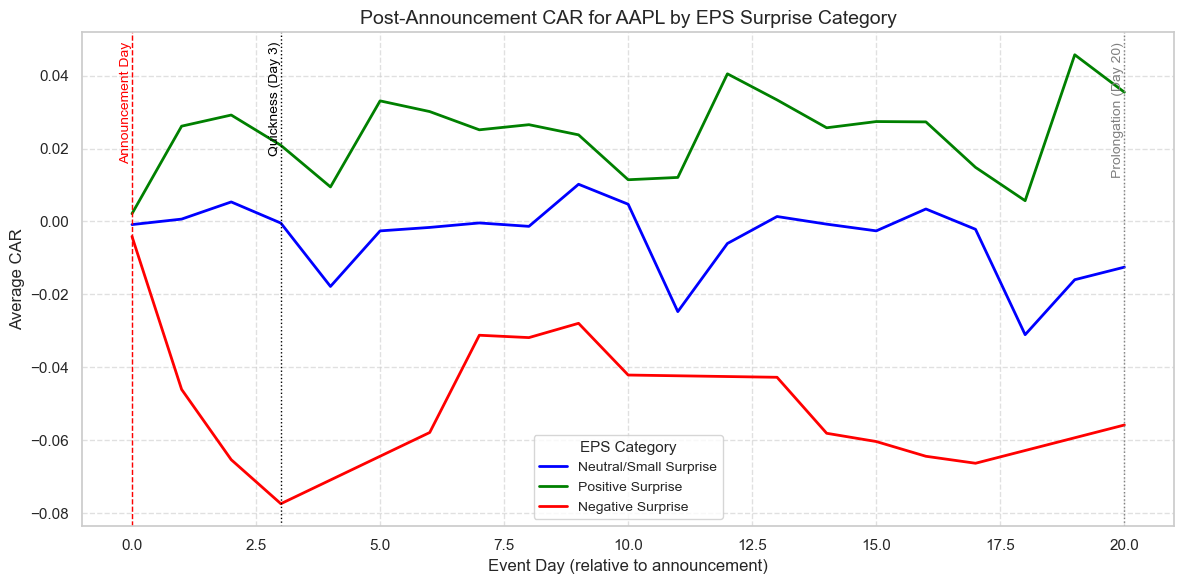

C:\Users\adyat\AppData\Local\Temp\ipykernel_35292\4151738409.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


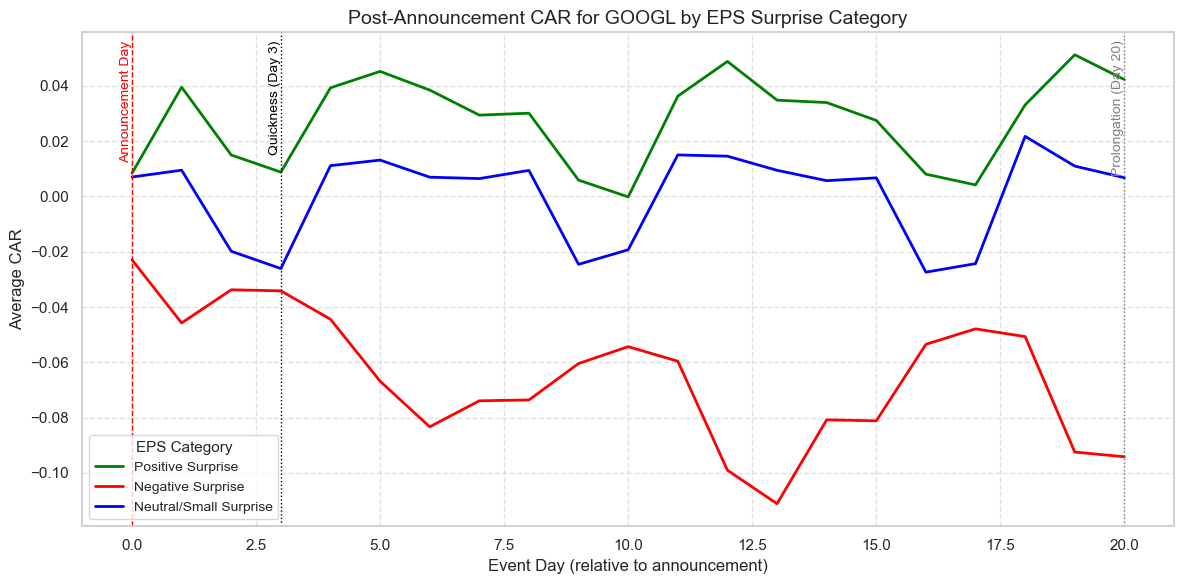

C:\Users\adyat\AppData\Local\Temp\ipykernel_35292\4151738409.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


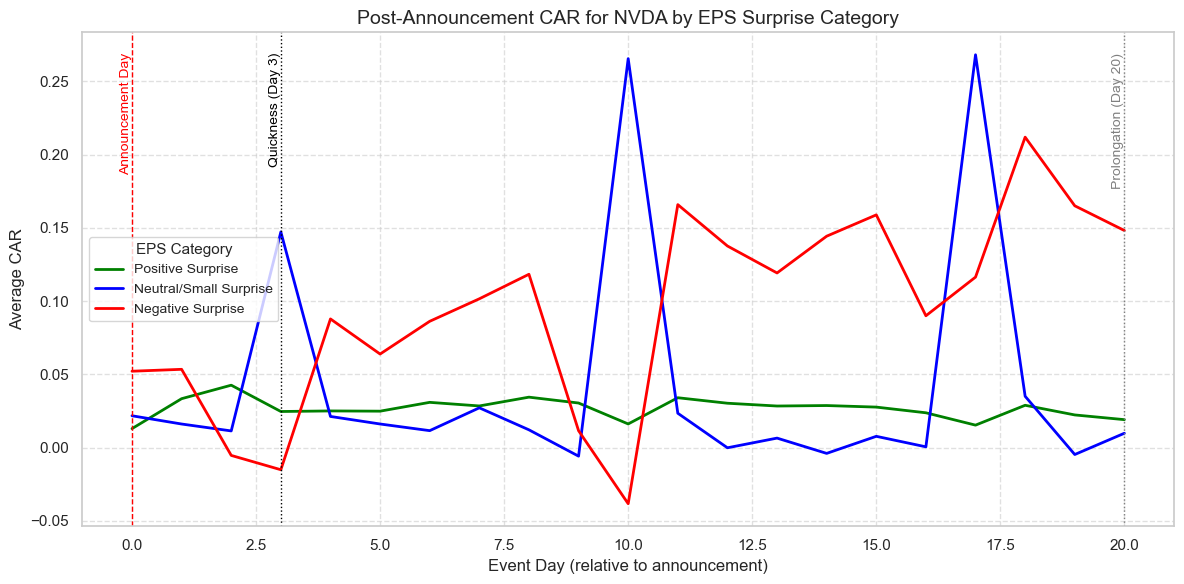

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

# Palette for EPS categories
palette = {
    "Negative Surprise": "red",
    "Neutral/Small Surprise": "blue",
    "Positive Surprise": "green"
}

for stock in post_announcement["ticker_from_id"].unique():
    subset = post_announcement[post_announcement["ticker_from_id"] == stock]

    plt.figure(figsize=(12,6))
    sns.lineplot(
        data=subset,
        x="event_day",
        y="CAR",
        hue="EPS_Category",
        palette=palette,
        linewidth=2,
        ci=None   # trend only, no shaded range
    )

    # Announcement day marker
    plt.axvline(x=0, color="red", linestyle="--", linewidth=1)
    plt.text(0, plt.ylim()[1]*0.95, "Announcement Day", rotation=90,
             color="red", ha="right", va="top", fontsize=10)

    # Quickness window marker (Day 3)
    plt.axvline(x=3, color="black", linestyle=":", linewidth=1)
    plt.text(3, plt.ylim()[1]*0.95, "Quickness (Day 3)", rotation=90,
             color="black", ha="right", va="top", fontsize=10)

    # Prolongation window marker (Day 20)
    plt.axvline(x=20, color="gray", linestyle=":", linewidth=1)
    plt.text(20, plt.ylim()[1]*0.95, "Prolongation (Day 20)", rotation=90,
             color="gray", ha="right", va="top", fontsize=10)

    # Titles and labels
    plt.title(f"Post-Announcement CAR for {stock} by EPS Surprise Category", fontsize=14)
    plt.xlabel("Event Day (relative to announcement)", fontsize=12)
    plt.ylabel("Average CAR", fontsize=12)
    plt.legend(title="EPS Category", fontsize=10, title_fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()